In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
#data_url = 'http://www.ndbc.noaa.gov/data/5day2/46022_5day.txt'
data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46244.txt'
#data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46022.txt'

# Set the number of hours to report.
parse = lambda x: pd.to_datetime(x, format='%Y %m %d %H %M')
buoy22_df = pd.read_csv(data_url, header=0, skiprows=[1], nrows=24, 
                        sep='\s+', na_values=['MM', -99], 
                        usecols=['#YY', 'MM', 'DD', 'hh', 'mm', 'WVHT', 'DPD', 'MWD'],
                        parse_dates={'Date':['#YY', 'MM', 'DD', 'hh', 'mm']}, 
                        date_parser=parse, index_col = 0)
buoy22_df.head()

,WVHT,DPD,MWD
Date,,,
2016-12-27 16:51:00,2.7,15,284
2016-12-27 16:21:00,2.3,15,278
2016-12-27 15:51:00,2.1,17,281
2016-12-27 15:21:00,2.4,15,277
2016-12-27 14:51:00,2.3,15,274


In [52]:
MWD_df = buoy22_df.copy()

# The data is reported in 'UTC'. Change local_time to desired time zone.
local_time = 'US/Pacific'
MWD_df = MWD_df.tz_localize('UTC')
MWD_df = MWD_df.tz_convert(local_time)

# Reset the index for plotting purposes.
MWD_df.reset_index(inplace=True)

# Convert meters to feet.
MWD_df['WVHT'] = MWD_df.apply(lambda x: np.around(x['WVHT'] * 3.4, decimals=1), 
                              axis=1)
MWD_df.head()

,Date,WVHT,DPD,MWD
0,2016-12-27 08:51:00-08:00,9.2,15,284
1,2016-12-27 08:21:00-08:00,7.8,15,278
2,2016-12-27 07:51:00-08:00,7.1,17,281
3,2016-12-27 07:21:00-08:00,8.2,15,277
4,2016-12-27 06:51:00-08:00,7.8,15,274


In [53]:
MWD_df.describe()

,WVHT,DPD,MWD
count,24.000000,24.000000,24.000000
mean,8.100000,15.958333,280.333333
std,0.509902,2.349453,8.281287
min,7.100000,10.000000,264.000000
25%,7.800000,15.000000,273.750000
50%,8.000000,17.000000,281.000000
75%,8.500000,17.000000,284.250000
max,9.200000,18.000000,298.000000


In [50]:
# Get data for plotting
# Convert swell direction from degrees to radians
theta = np.deg2rad(MWD_df[['MWD']])
period = MWD_df[['DPD']]

# Times are indexed with ints starting at 2 so that MWD can be detected.
r = MWD_df.index+2

# Get info for title string
# Max and min hights will be reported in feet
height_min = MWD_df[['WVHT']].min().values
height_max = MWD_df[['WVHT']].max().values
hts_str =  str(height_min) + '\' to ' + str(height_max) + '\''

# Get most current time reported and convert it from 'UTC' to 'PDT'
date_str = str(MWD_df[['Date']].iloc[-1].ctime())
tlt_str = 'Buoy 22 Last 24 Reports ' + '\n' + date_str + '\n Hts ' + hts_str

# Get most current data
latest_wht = str(float(MWD_df[['WVHT']].iloc[0].values))
latest_dpd = str(float(MWD_df[['DPD']].iloc[0].values))
latest_mwd = str(float(MWD_df[['MWD']].iloc[0].values))
latest_str = date_str + '\n' + latest_wht + ' ft @ ' + latest_dpd + ' sec' + '\n' + 'Direction: ' + latest_mwd 

# Scale point sizes based on max and min wave height
SMALL_PNT_SZ = 20
LARGE_PNT_SZ = 200
diff = LARGE_PNT_SZ - SMALL_PNT_SZ
m = np.divide(diff, height_max - height_min)
b = (SMALL_PNT_SZ * height_max - LARGE_PNT_SZ * height_min) / (height_max - height_min)

pnt_sz = m*MWD_df[['WVHT']] + b

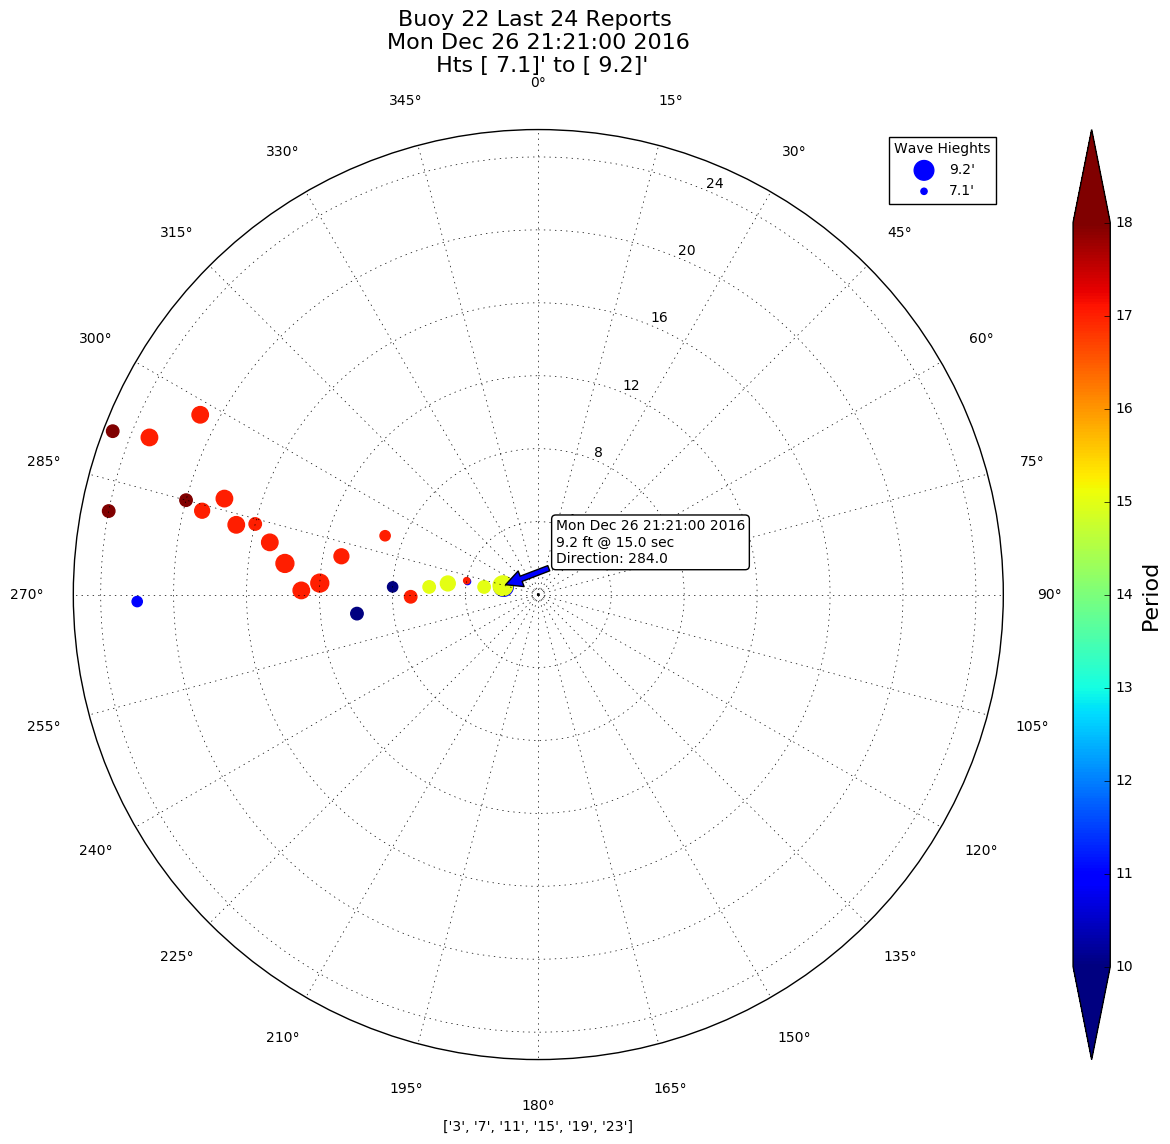

In [64]:
#my_plot = 
plt.rcParams['figure.figsize'] =[18, 12]

ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
theta_tics = np.arange(0, 360, 15)
ax.set_thetagrids(theta_tics)
ax.set_rlim([0, 25.5])
r_tics = np.arange(4, 28, 4)
ax.set_rgrids(r_tics)
ax.grid(True)

big_idx = pnt_sz.idxmax()
small_idx = pnt_sz.idxmin()

big_str = str(float(MWD_df.iloc[big_idx]['WVHT'])) + "'"
small_str = str(float(MWD_df.iloc[small_idx]['WVHT'])) + "'"

#### These two plots are still visable after plotting the main plot. ####
big = ax.scatter(theta.iloc[big_idx], r[int(big_idx)], s=pnt_sz.iloc[big_idx], edgecolors='face')
small = ax.scatter(theta.iloc[small_idx], r[int(small_idx)], s=pnt_sz.iloc[small_idx], edgecolors='face')

p = ax.scatter(theta, r, s=pnt_sz, c=period, edgecolors='face')

cbar = plt.colorbar(p, extend='both', extendfrac=0.125)
cbar.set_label('Period', fontsize=16)
cbar.set_ticks(np.arange(period.min(), period.max() + 1))

ax.set_title(tlt_str, va='bottom', fontsize=16)

thistheta = theta.iloc[0]
thisr = r[0]
ax.annotate(latest_str,
            xy=(thistheta, thisr),  # theta, radius
            xytext=(0.5, 2),    # fraction, fraction
            bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(facecolor='blue', shrink=0.05)
            )

# Plot legend.
#lgnd = 
plt.legend([big_str, small_str], loc="upper right", scatterpoints=1, fontsize=10, title='Wave Hieghts')
ax.set_xlabel(['3', '7', '11', '15', '19', '23'])

plt.show(ax)

In [62]:
dir(ax)

['InvertedPolarTransform',
 'PolarAffine',
 'PolarTransform',
 'RadialLocator',
 'ThetaFormatter',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_axisbg',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_cursorProps',
 '_default_rlabel_position',
 '_default_theta_direction',
 '_default_theta_offset',
 '_direction',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_legend_handles',
 